In [1]:
from src import *

## Goal

The goal of this notebook is to do create paths (voxel level) to match pairs of regions with highest connectivity paths

## Description
Generate paths according to the functional connectivity of pairs of regions. 
- E.g using highest sum of energy (energy being positive correlation)

### Loading the existing inpainted paths according to regions of interest

In [19]:
wmall = load('./l2regC_scale1_occipital_30/wm_inpainted_all.pkl')
wmreg = load('./l2regC_scale1_occipital_30/wm_inpainted_rec.pkl')

rest_runs = os.listdir('../atlas_data/rstfMRI_eg/rst_fmri_moviedata/')
rst_vols = [nib.load('../atlas_data/rstfMRI_eg/rst_fmri_moviedata/{}'.format(run)) for run in rest_runs]
rest_affine = rst_vols[0].affine

connFilename = '../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale1.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = len(gmregions_names)
bundle_affine = np.array(hf.get('header').get('affine'))[()]

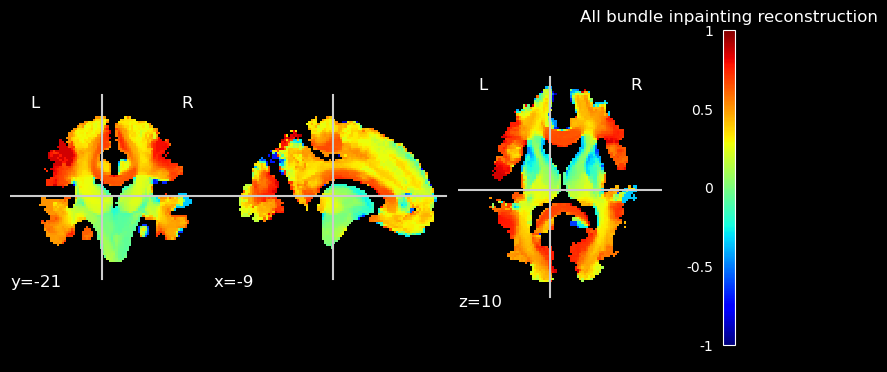

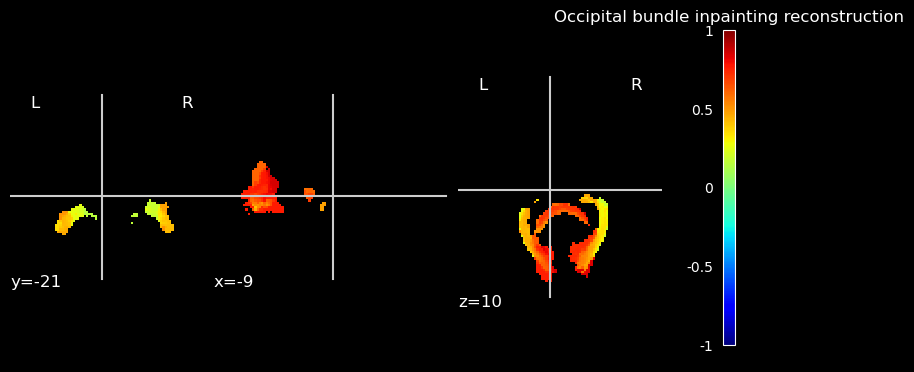

In [11]:
cmap = mpl.colormaps.get_cmap('jet')
cmap.set_extremes(under='black', over='black')
plot_epi(nib.Nifti1Image(wmall, affine=rest_affine),colorbar=True, cut_coords=(-9,-21,10), 
         cmap=cmap, vmin=-1, vmax=1)
plt.title('All bundle inpainting reconstruction', color='white')
plt.show()

plot_epi(nib.Nifti1Image(wmreg, affine=rest_affine),colorbar=True, cut_coords=(-9,-21,10), 
         cmap=cmap, vmin=-1, vmax=1)
plt.title('Occipital bundle inpainting reconstruction', color='white')
plt.show()

### Path Selection
From the regions part of bundles we select a path (array of voxels that lead from the region of interest to any other regions)

In [13]:
# Get the bundle from one arbitrary region to the region of interest
bundle_vox = load('./l2regC_scale1_occipital_30/bundlevox_coords.pkl')

In [17]:
# isolating region of interest that we want to compute the connectivity inpainting from
region_of_interest = ['ctx-rh-lateraloccipital', 'ctx-lh-lateraloccipital']
index_of_interest = [np.where(gmregions_names.astype(str) == r)[0][0] 
                     for r in region_of_interest]

In [20]:
thresh_subjapp = int(np.ceil(nsubject * 0.3)) # consider bundles that appaear at least in 30 % of the subjects    

bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))

100%|██████████| 95/95 [00:32<00:00,  2.90it/s]


In [51]:
# get_path from given index to region of interest
tidx = 18
print(gmregions_names[tidx])
bundle_index_target = []
for k in range(len(bundles_labels)):
    i,j = bundles_labels[k]
    cond1 = ((i in index_of_interest) or (j in index_of_interest))
    cond2 = (i==tidx) or (j==tidx)
    if cond1 and cond2:
        bundle_index_target.append(k)
bundle_index_target

b'ctx-rh-inferiorparietal'


[493, 523]

In [62]:
# create mask of paths to then populate with wmreg inpainted and then generate paths
pathcoords = np.concatenate([bundle_vox[493], bundle_vox[523]])
path2inpaint = np.sign(wmreg) * -100 # out of bounds making

for coords in pathcoords:
    x,y,z = coords
    path2inpaint[x,y,z] = 1.0

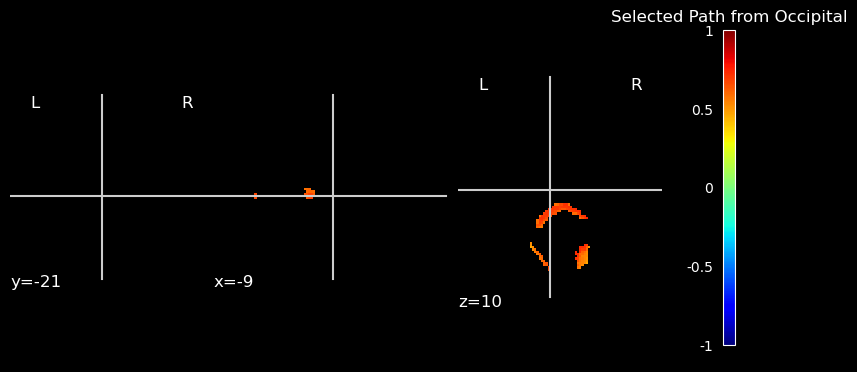

In [65]:
restraint_path = path2inpaint * wmreg
plot_epi(nib.Nifti1Image(restraint_path, affine=rest_affine),colorbar=True, cut_coords=(-9,-21,10), 
         cmap=cmap, vmin=-1, vmax=1)
plt.title('Selected Path from Occipital', color='white')
plt.show()

In [69]:
# thresholding the correlation to refine the path?
thresh_path = (restraint_path > 0.5) * restraint_path

# this would then be a path choice that makes sense in the bundle idea
# we cannot however extract a single streamline path due to the fact that we are working with bundles only

In [ ]:
# display region path frm region of interest to all other regions